In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, pacf

## Data Preprocessing

In [253]:
data = pd.read_excel('/content/drive/MyDrive/Time Series HWs/cankaya.xlsx')
data.head(10)

,Tarih,Unnamed: 1
0,NaT,PM 2.5 ( µg/m³ )
1,2016-01-01 00:00:00,"20,13"
2,2016-01-01 01:00:00,"2,27"
3,2016-01-01 02:00:00,"7,41"
4,2016-01-01 03:00:00,"4,62"
5,2016-01-01 04:00:00,"15,19"
6,2016-01-01 05:00:00,"4,76"
7,2016-01-01 06:00:00,"15,77"
8,2016-01-01 07:00:00,"9,84"
9,2016-01-01 08:00:00,"32,37"


In [254]:
data.tail(10)

,Tarih,Unnamed: 1
35575,2020-01-22 06:00:00,-
35576,2020-01-22 07:00:00,-
35577,2020-01-22 08:00:00,-
35578,2020-01-22 09:00:00,-
35579,2020-01-22 10:00:00,-
35580,2020-01-22 11:00:00,-
35581,2020-01-22 12:00:00,"15,77"
35582,2020-01-22 13:00:00,"18,63"
35583,2020-01-22 14:00:00,"13,34"
35584,2020-01-22 15:00:00,"15,73"


Converted the column values to datetime inclusing the time

In [255]:
data['Tarih'] = pd.to_datetime(data['Tarih'], format='%d.%m.%Y %H:%M:%S')

In [256]:
data = data.rename(columns={'Unnamed: 1': 'PM 2.5'})

Here, I dropped the row of the column titles

In [258]:
data = data.drop(data.index[0])

### Handling Missing Data

Here I replaced the cells containing '-' or ' ' with NaN

In [259]:
data['PM 2.5'] = data['PM 2.5'].replace(['-', ''], np.nan)

In [252]:
data.head(10)

,Tarih,Unnamed: 1
0,NaT,PM 2.5 ( µg/m³ )
1,2016-01-01 00:00:00,"20,13"
2,2016-01-01 01:00:00,"2,27"
3,2016-01-01 02:00:00,"7,41"
4,2016-01-01 03:00:00,"4,62"
5,2016-01-01 04:00:00,"15,19"
6,2016-01-01 05:00:00,"4,76"
7,2016-01-01 06:00:00,"15,77"
8,2016-01-01 07:00:00,"9,84"
9,2016-01-01 08:00:00,"32,37"


In [260]:
data.tail(10)

,Tarih,PM 2.5
35575,2020-01-22 06:00:00,NaN
35576,2020-01-22 07:00:00,NaN
35577,2020-01-22 08:00:00,NaN
35578,2020-01-22 09:00:00,NaN
35579,2020-01-22 10:00:00,NaN
35580,2020-01-22 11:00:00,NaN
35581,2020-01-22 12:00:00,"15,77"
35582,2020-01-22 13:00:00,"18,63"
35583,2020-01-22 14:00:00,"13,34"
35584,2020-01-22 15:00:00,"15,73"


### Data Cleaning

In [261]:
data['PM 2.5'] = pd.to_numeric(data['PM 2.5'].str.replace(',', '.'), errors='coerce')

To replace NaN with values, I used backward and forward fill.

In [262]:
data['PM 2.5'] = data['PM 2.5'].bfill().ffill()

For better estimation of values, I used interpolation for a smoother estimates around the data

In [263]:
data['PM 2.5'] = data['PM 2.5'].interpolate(method='linear')

In [264]:
data.head(10)

,Tarih,PM 2.5
2,2016-01-01 01:00:00,2.27
3,2016-01-01 02:00:00,7.41
4,2016-01-01 03:00:00,4.62
5,2016-01-01 04:00:00,15.19
6,2016-01-01 05:00:00,4.76
7,2016-01-01 06:00:00,15.77
8,2016-01-01 07:00:00,9.84
9,2016-01-01 08:00:00,32.37
10,2016-01-01 09:00:00,0.95
11,2016-01-01 10:00:00,3.13


In [265]:
data.tail(10)

,Tarih,PM 2.5
35575,2020-01-22 06:00:00,15.77
35576,2020-01-22 07:00:00,15.77
35577,2020-01-22 08:00:00,15.77
35578,2020-01-22 09:00:00,15.77
35579,2020-01-22 10:00:00,15.77
35580,2020-01-22 11:00:00,15.77
35581,2020-01-22 12:00:00,15.77
35582,2020-01-22 13:00:00,18.63
35583,2020-01-22 14:00:00,13.34
35584,2020-01-22 15:00:00,15.73


In [266]:
# Checking if all missing values are filled
print(data.isnull().sum())

Tarih     0
PM 2.5    0
dtype: int64


## Model Building

This is to check whether the data is stationary, and because p-value < 0.05, we reject the null hypothesis and conclude that the time series is stationary


In [267]:
result = adfuller(data['PM 2.5'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -14.462788267806632
p-value: 6.80366158225306e-27


 ### Choosing Model Parameters

We perform PACF, since it's more suitable for AR models. Based on the plot, the optimal lag is 2. Which means AR(2) is the suitable model


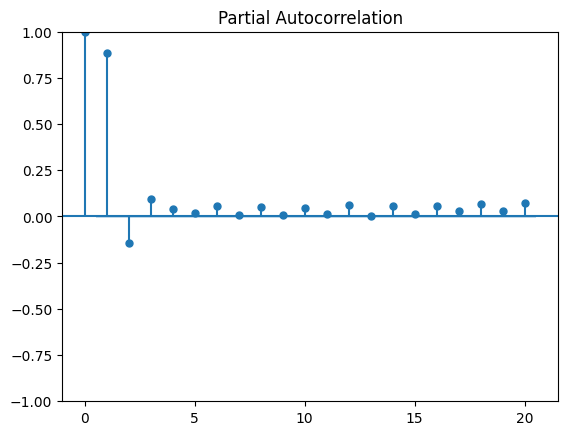

In [268]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data['PM 2.5'], lags=20)
plt.show()


### Model Fitting

AR(2)

In [269]:
from statsmodels.tsa.ar_model import AutoReg

p = 2

data['PM 2.5'] = data['PM 2.5'].interpolate(method='linear')

data = data.dropna(subset=['PM 2.5'])

data = data.reset_index(drop=True)

model = AutoReg(data['PM 2.5'], lags=p, old_names=False)
model_fit = model.fit()

print(model_fit.summary())


                            AutoReg Model Results                             
Dep. Variable:                 PM 2.5   No. Observations:                35583
Model:                     AutoReg(2)   Log Likelihood             -125791.285
Method:               Conditional MLE   S.D. of innovations              8.301
Date:                Sat, 26 Oct 2024   AIC                         251590.570
Time:                        13:08:00   BIC                         251624.488
Sample:                             2   HQIC                        251601.365
                                35583                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3011      0.062     36.957      0.000       2.179       2.423
PM 2.5.L1      1.0116      0.005    192.790      0.000       1.001       1.022
PM 2.5.L2     -0.1430      0.005    -27.253      0.0

The AR1 and AR2 roots are both > 1, 1.1881 and 5.8859 respectively, which confirm that the time series is stationary.

In [270]:
residuals = model_fit.resid

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


       lb_stat     lb_pvalue
10  400.282917  8.194621e-80


The majority of the residuals are centered  around zero. This means that the model's predictions are very close to the actual values most of the time. Which means the model is adequate.

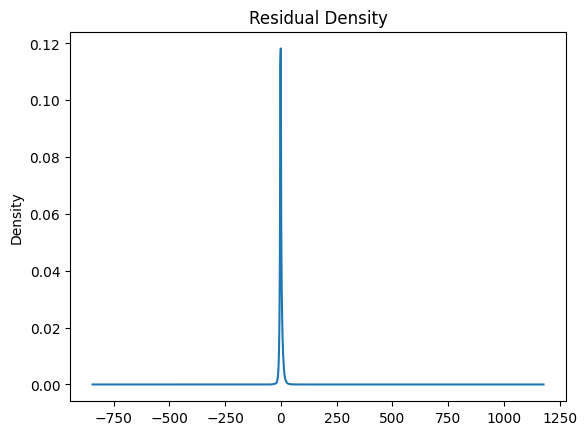

In [271]:
residuals.plot(kind='kde')
plt.title('Residual Density')
plt.show()

## Conclusion

After handling the missing values with linear interpolation, we ran an ADF test to check if the PM2.5 time series was stationary, and the results confirmed it (ADF Statistic = -14.4600, p-value < 0.05). Based on the PACF plot, we decided that an AR(2) model was the best fit. All the coefficients in the AR(2) model turned out to be statistically significant.